# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [3]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift
from sklearn.preprocessing import scale

from sklearn.ensemble import AdaBoostRegressor # Adaptive Boosting
from sklearn.ensemble import GradientBoostingRegressor # Gradient Tree Boosting
from xgboost.sklearn import XGBRegressor # Extreme Gradient Boosting
import xgboost as xgb

from sklearn.metrics import roc_auc_score, fbeta_score, accuracy_score, precision_score, recall_score

from scipy import stats
from time import time

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [4]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# Set pandas display to be able to scroll through all columns and rows
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows',200)

In [6]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,...,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KK_KUNDENTYP,KKK,KOMBIALTER,KONSUMNAEHE,KONSUMZELLE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,MOBI_RASTER,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,PRAEGENDE_JUGENDJAHRE,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,10,10,10,NaN,0,0,0,NaN,9,0,0,NaN,NaN,0,0,0,0,0,0,NaN,0,0,0,10,0,10,10,NaN,0,0,0,0,10,10,10,NaN,0,0,0,10,10,10,NaN,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN,NaN,2.0,2.0,15.0,4.0,1.0,1.0,NaN,NaN,NaN,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,5.0,1.0,4.0,1.0,6,3,6,6,7,3,5,5,5,4,7,2,3,1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,8A,8,51,5.0,1.0,5.0,5.0,2.0,3.0,1.0,1.0,0,0,10,0,0,0,10,10,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,10,10,10,NaN,0,0,0,NaN,9,0,0,NaN,NaN,0,0,0,0,0,0,NaN,0,0,0,10,0,10,10,NaN,0,0,0,0,10,10,10,NaN,0,0,0,10,10,10,NaN,0,0,0,1.0,1992-02-10 00:00:00,2004.0,3.0,...,2.0,3.0,2

In [7]:
list(azdias.columns)

['LNR',
 'AGER_TYP',
 'AKT_DAT_KL',
 'ALTER_HH',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ALTERSKATEGORIE_FEIN',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_KINDER',
 'ANZ_PERSONEN',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'ANZ_TITEL',
 'ARBEIT',
 'BALLRAUM',
 'CAMEO_DEU_2015',
 'CAMEO_DEUG_2015',
 'CAMEO_INTL_2015',
 'CJT_GESAMTTYP',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_LOKAL',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_BANKEN_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST',
 'D19_BILDUNG',
 'D19_BIO_OEKO',
 'D19_BUCH_CD',
 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL',
 'D19_ENERGIE',
 'D19_FREIZEIT',
 'D19_GARTEN',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE

In [8]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,...,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KK_KUNDENTYP,KKK,KOMBIALTER,KONSUMNAEHE,KONSUMZELLE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,MOBI_RASTER,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,PRAEGENDE_JUGENDJAHRE,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,3.0,1A,1,13,5.0,4.0,1.0,1.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,0,0,0,6,0,0,0,0,0,0,0,9,9,10,0.0,0,6,0,3.0,2,0,6,D19_UNBEKANNT,0.0,0,0,0,6,0,6,1.0,6,0,0,10,0,10,10,0.0,0,0,0,0,9,9,10,0.0,0,0,0,10,10,10,0.0,0,0,0,1.0,1992-02-12 00:00:00,1994.0,2.0,...,3.0,4.0,3.0,3.0,2.0,2.0,3.0,5.0,2.0,2.0,3.0,3.0,1.0,3.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,3.0,1.0,5.0,2.0,4.0,3.0,3.0,3.0,1.0,4.0,NaN,1.0,4,5.0,0.0,2.0,2.0,20.0,5.0,10.0,5.0,1992.0,3.0,4.0,1,3.0,2.0,W,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4,1.0,1.0,5.0,1.0,5.0,3.0,1,3,5,1,3,4,7,6,2,1,2,6,1,6,3,0.0,3.0,0.0,4.0,4.0,0.0,8.0,1,0.0,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,6,0,5,0,10,10,0.0,6,0,0,0,0,0,0,6,0,0,0,0,1,6,10,9,0.0,0,0,0,5.0,3,0,0,D19_BANKEN_GROSS,0.0,0,0,0,0,0,0,0.0,0,0,0,10,0,10,10,0.0,0,0,0,0,9,10,9,0.0,0,0,0,10,10,10,0

In [9]:
list(customers.columns)

['LNR',
 'AGER_TYP',
 'AKT_DAT_KL',
 'ALTER_HH',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ALTERSKATEGORIE_FEIN',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_KINDER',
 'ANZ_PERSONEN',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'ANZ_TITEL',
 'ARBEIT',
 'BALLRAUM',
 'CAMEO_DEU_2015',
 'CAMEO_DEUG_2015',
 'CAMEO_INTL_2015',
 'CJT_GESAMTTYP',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_LOKAL',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_BANKEN_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST',
 'D19_BILDUNG',
 'D19_BIO_OEKO',
 'D19_BUCH_CD',
 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL',
 'D19_ENERGIE',
 'D19_FREIZEIT',
 'D19_GARTEN',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE

In [10]:
differences = []
for i in customers.columns:
    if i not in azdias:
        differences.append(i)
        
print(differences)

['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']


In [11]:
# Structure of dataframe; followed by investigation cells
azdias.shape
print('Number of rows:', azdias.shape[0])
print('Number of columns', azdias.shape[1])

Number of rows: 891221
Number of columns 366


In [12]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [13]:
azdias['AGER_TYP'].unique()

array([-1,  2,  3,  0,  1])

In [14]:
azdias.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LNR,891221.0,637263.000000,257273.486466,191653.0,414458.0,637263.0,860068.0,1082873.0
AGER_TYP,891221.0,-0.358435,1.198724,-1.0,-1.0,-1.0,-1.0,3.0
AKT_DAT_KL,817722.0,4.421928,3.638805,1.0,1.0,3.0,9.0,9.0
ALTER_HH,817722.0,10.864126,7.639683,0.0,0.0,13.0,17.0,21.0
ALTER_KIND1,81058.0,11.745392,4.097660,2.0,8.0,12.0,15.0,18.0
ALTER_KIND2,29499.0,13.402658,3.243300,2.0,11.0,14.0,16.0,18.0
ALTER_KIND3,6170.0,14.476013,2.712427,4.0,13.0,15.0,17.0,18.0
ALTER_KIND4,1205.0,15.089627,2.452932,7.0,14.0,15.0,17.0,18.0
ALTERSKATEGORIE_FEIN,628274.0,13.700717,5.079849,0.0,11.0,14.0,17.0,25.0
ANZ_HAUSHALTE_AKTIV,798073.0,8.287263,15.628087,0.0,1.0,4.0,9.0,595.0


## Handling Missing Data

In [15]:
# find data that is 'naturally missing' in dataset
# get number of nan/null data in azdias before any processing is applied
# total number of fields with null - 'naturally'
azdias_null = azdias.isnull().sum()
azdias_null_percentage = azdias_null / len(azdias) * 100

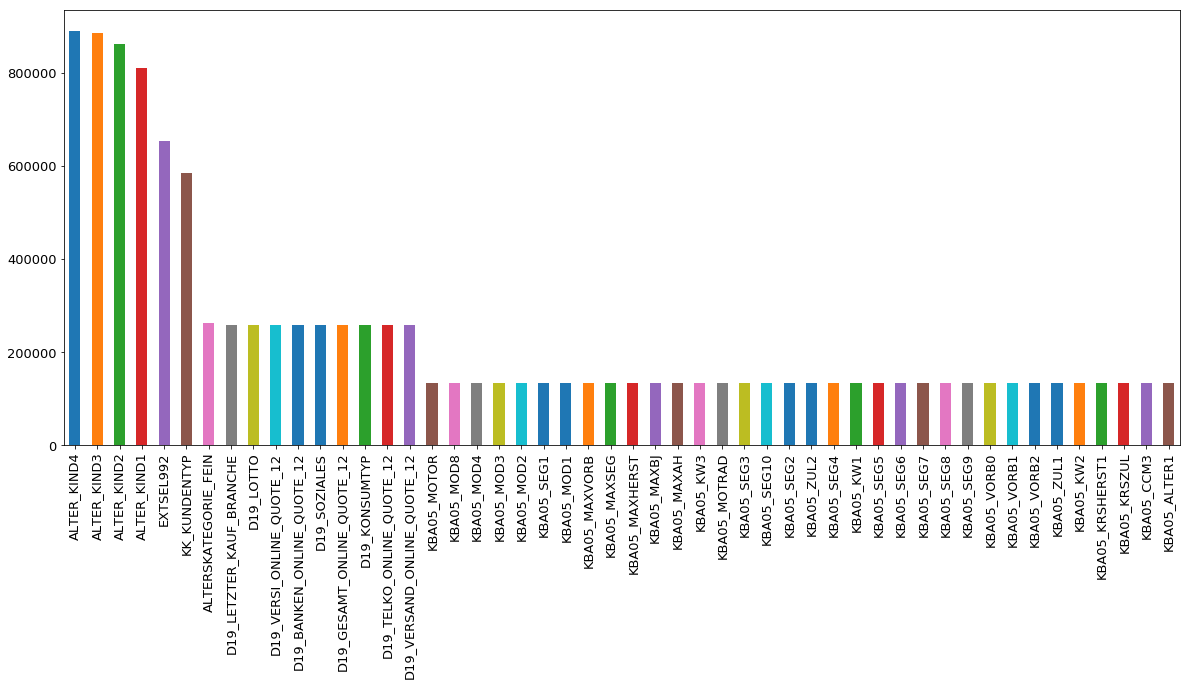

In [16]:
# visualise natually missing data
(azdias_null.sort_values(ascending = False)[:50].plot(kind='bar', figsize=(20,8), fontsize=13))

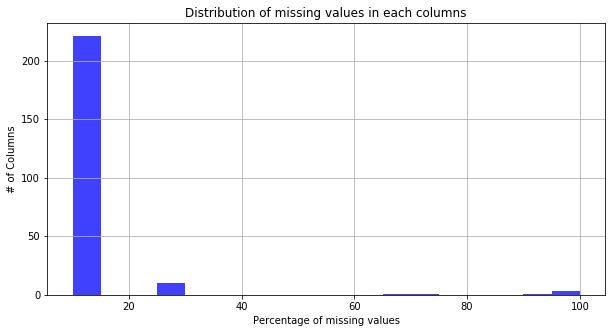

In [17]:
# get dstribution of empty data in fields by percentage
plt.figure(figsize=(10,5))
plt.hist(azdias_null_percentage, bins = np.linspace(10,100,19), facecolor='b', alpha = 0.75)

plt.xlabel('Percentage of missing values')
plt.ylabel('# of Columns')
plt.title('Distribution of missing values in each columns')
plt.grid(True)

plt.show()

In [18]:
# % of missing data in columns
print('% of missing data in columns','\n',azdias_null_percentage.sort_values(ascending=False))

% of missing data in columns 
 ALTER_KIND4                    99.864792
ALTER_KIND3                    99.307691
ALTER_KIND2                    96.690047
ALTER_KIND1                    90.904837
EXTSEL992                      73.399639
KK_KUNDENTYP                   65.596749
ALTERSKATEGORIE_FEIN           29.504130
D19_LETZTER_KAUF_BRANCHE       28.849522
D19_LOTTO                      28.849522
D19_VERSI_ONLINE_QUOTE_12      28.849522
D19_BANKEN_ONLINE_QUOTE_12     28.849522
D19_SOZIALES                   28.849522
D19_GESAMT_ONLINE_QUOTE_12     28.849522
D19_KONSUMTYP                  28.849522
D19_TELKO_ONLINE_QUOTE_12      28.849522
D19_VERSAND_ONLINE_QUOTE_12    28.849522
KBA05_MOTOR                    14.959701
KBA05_MOD8                     14.959701
KBA05_MOD4                     14.959701
KBA05_MOD3                     14.959701
KBA05_MOD2                     14.959701
KBA05_SEG1                     14.959701
KBA05_MOD1                     14.959701
KBA05_MAXVORB             

Text(0,0.5,'prop. of missing values')

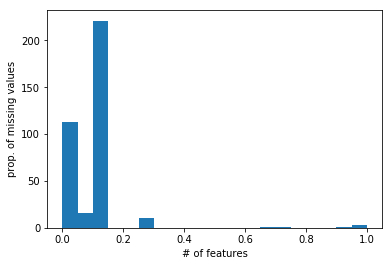

In [19]:
# above we have already identified %  of nan/null values columnwise
# let's visualise the distribution trend 
column_nans = azdias.isnull().mean()

plt.hist(column_nans, bins = np.arange(0,1+.05,.05))
plt.xlabel('# of features')
plt.ylabel('prop. of missing values')

In [20]:
# From review of data in last 2 cells, we can find that % of null data in columns ranges from 0.* to 17% 
# but after that there is drastic difference in % of null fields clearly highlighting outliers. 
# Let's print missing % distribution manually to understand if outlier is evidently visible or further analysis/deep dive required

print('columns having  missing values >0% : ',len(azdias_null_percentage[azdias_null_percentage>0].index))
print('columns having  missing values >10%: ',len(azdias_null_percentage[azdias_null_percentage>10].index))
print('columns having  missing values >20%: ',len(azdias_null_percentage[azdias_null_percentage>20].index))
print('columns having  missing values >30%: ',len(azdias_null_percentage[azdias_null_percentage>30].index))
print('columns having  missing values >40%: ',len(azdias_null_percentage[azdias_null_percentage>40].index))
print('columns having  missing values >60%: ',len(azdias_null_percentage[azdias_null_percentage>60].index))
print('columns having  missing values >65%: ',len(azdias_null_percentage[azdias_null_percentage>65].index))
print('columns having  missing values >80%: ',len(azdias_null_percentage[azdias_null_percentage>80].index))
print('columns having  missing values >90%: ',len(azdias_null_percentage[azdias_null_percentage>90].index))

columns having  missing values >0% :  273
columns having  missing values >10%:  237
columns having  missing values >20%:  16
columns having  missing values >30%:  6
columns having  missing values >40%:  6
columns having  missing values >60%:  6
columns having  missing values >65%:  6
columns having  missing values >80%:  4
columns having  missing values >90%:  4


Text(0.5,0,'# of missing values')

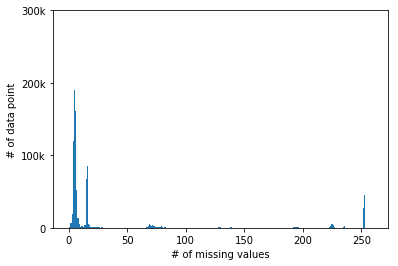

In [21]:
# distribution analysis on row level

row_nans = azdias.isnull().sum(axis=1)
plt.hist(row_nans, bins = np.arange(-0.5, row_nans.max()+1, 1))
plt.yticks(np.arange(0,300000+100000,100000),['0', '100k','200k','300k'])
plt.ylabel('# of data point')
plt.xlabel('# of missing values')

Text(0.5,0,'# of missing values')

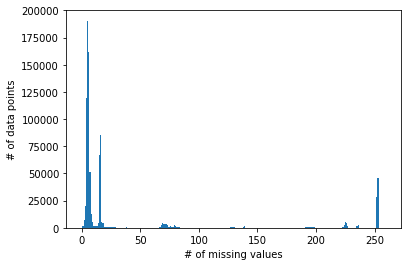

In [22]:
# as 0 has most of the data, we are unable to see rest of the trend in detail. 
# So plotting distribution without 0 missing values from below chart we can that around 9ish trend starts changing.

row_nans = azdias[azdias.isnull().sum(axis=1) > 0].isnull().sum(axis=1)
plt.hist(row_nans, bins = np.arange(-0.5,row_nans.max()+1,1))
plt.ylabel('# of data points')
plt.xlabel('# of missing values')

In [23]:
# let's see this in a slightly different way.
# Calculate percentage of data kept for rows with * or less missing data points
# from below we can see that % of data kept for rows with various number of missing data points (in asc order)
# from this we can see that around 16% this more or less stagnates and increase in number of columns does not directly increase % of data kept.
# so we will use this as an indicator to help us choose the threshold limit.

print("Percentage of data kept:",round(azdias.isnull().sum(axis=1).value_counts().sort_index().cumsum()[:30]/azdias.isnull().sum(axis=1).shape[0]*100,0))

Percentage of data kept: 0      0.0
1      0.0
2      1.0
3      3.0
4     17.0
5     38.0
6     56.0
7     62.0
8     63.0
9     64.0
10    64.0
11    64.0
12    65.0
13    65.0
14    65.0
15    73.0
16    82.0
17    83.0
18    83.0
19    83.0
20    84.0
21    84.0
22    84.0
23    84.0
24    84.0
25    84.0
26    84.0
27    84.0
28    84.0
29    84.0
dtype: float64


In [24]:
azdias = azdias[azdias.isnull().sum(axis=1) <= 16].reset_index(drop=True)
print('number of rows in new dataset: ',azdias.shape[0])

number of rows in new dataset:  733227


In [25]:
# from above we can see that there is significant difference on % of data missing. >65 is only 6 columns and this is a significant missing data
# so let's drop these 6 columns

drop_cols = azdias.columns[column_nans > 0.65]
print('columns to drop: ', drop_cols)

columns to drop:  Index(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992',
       'KK_KUNDENTYP'],
      dtype='object')


In [26]:
print('number of rows in new dataset: ',azdias.shape[0])

number of rows in new dataset:  733227


In [27]:
# Before dropping data on azdias lets preprocess customers dataset and get it ready for further processing
# Drop the extra column of customers dataset.

customers.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)

In [28]:
print('# of column in azdias before dropping: ', len(azdias.columns))
azdias = azdias.drop(drop_cols,axis=1)
print('# of column in azdias after dropping: ', len(azdias.columns))

print('# of column in customers before dropping: ', len(customers.columns))
customers = customers.drop(drop_cols,axis=1)
print('# of column in customers after dropping: ', len(customers.columns))

# of column in azdias before dropping:  366
# of column in azdias after dropping:  360
# of column in customers before dropping:  366
# of column in customers after dropping:  360


In [29]:
print('number of rows in new dataset: ',azdias.shape)
print('number of rows in new dataset: ',customers.shape)

number of rows in new dataset:  (733227, 360)
number of rows in new dataset:  (191652, 360)


In [30]:
# object field EINGEFUEGT_AM has too many different items. Dropping from dataset

azdias = azdias.drop(['EINGEFUEGT_AM'],axis=1)
customers = customers.drop(['EINGEFUEGT_AM'],axis=1)

In [31]:
%%time
# introducing this new clean up step - as without this we end up with 406 columns after one-hot encoding
# reduce number of columns further by trying to removing highly correlated columns
# idea and approach from Chris Albon's website https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/


# find correlation matrix    
corr_matrix = azdias.corr().abs()
upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# identify columns to drop based on threshold limit
drop_columns = [column for column in upper_limit.columns if any(upper_limit[column] > .7)]
# drop columns from azdias
azdias = azdias.drop(drop_columns, axis=1)
print('number of columns', len(azdias.columns))

# repeat for customers
# find correlation matrix    
corr_matrix = customers.corr().abs()
upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# identify columns to drop based on threshold limit
drop_columns = [column for column in upper_limit.columns if any(upper_limit[column] > .7)]
# drop columns from azdias
customers = customers.drop(drop_columns, axis=1)
print('number of columns', len(customers.columns))


number of columns 239
number of columns 257
CPU times: user 4min 36s, sys: 7.81 s, total: 4min 44s
Wall time: 6min 36s


In [32]:
print('number of rows in new dataset: ',azdias.shape)
print('number of rows in new dataset: ',customers.shape)

number of rows in new dataset:  (733227, 239)
number of rows in new dataset:  (191652, 257)


In [33]:
# we have removed columns that has mostly missing values and do not add value. Let's explore columns with object data type.
azdias.select_dtypes(include=['object'])

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,OST_WEST_KZ
0,8A,8,51,NaN,W
1,4C,4,24,D19_UNBEKANNT,W
2,2A,2,12,D19_UNBEKANNT,W
3,6B,6,43,D19_SCHUHE,W
4,8C,8,54,D19_ENERGIE,W
5,4A,4,22,D19_UNBEKANNT,W
6,2D,2,14,D19_UNBEKANNT,W
7,1A,1,13,NaN,W
8,1E,1,15,D19_KOSMETIK,W
9,9D,9,51,D19_UNBEKANNT,W


In [34]:
print('number of columns', len(azdias.columns))

number of columns 239


In [35]:
customers.select_dtypes(include=['object']).head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,OST_WEST_KZ
0,1A,1,13,D19_UNBEKANNT,W
1,NaN,NaN,NaN,D19_BANKEN_GROSS,NaN
2,5D,5,34,D19_UNBEKANNT,W
3,4C,4,24,D19_NAHRUNGSERGAENZUNG,W
4,7B,7,41,D19_SCHUHE,W


In [36]:
# before going ahead with encoding we need to find categorical fields - below 1 hack option to do it

cols = azdias.columns
num_cols = azdias._get_numeric_data().columns
print('num_cols: ',num_cols)
print('categorical: ',list(set(cols) - set(num_cols)))

num_cols:  Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_TITEL',
       ...
       'UMFELD_ALT', 'UMFELD_JUNG', 'UNGLEICHENN_FLAG', 'VERDICHTUNGSRAUM',
       'VERS_TYP', 'VHA', 'VHN', 'W_KEIT_KIND_HH', 'WOHNLAGE', 'ZABEOTYP'],
      dtype='object', length=234)
categorical:  ['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'CAMEO_INTL_2015', 'OST_WEST_KZ', 'CAMEO_DEUG_2015']


In [37]:
# we need to fill missing values here. We will fill missing values with -1 indicating unknown as in the description.

azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].replace(['X','XX'],-1)
customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].replace(['X','XX'],-1)
azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].fillna(-1)
customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].fillna(-1)
azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(int)
customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(int)
azdias[['CAMEO_DEU_2015','OST_WEST_KZ']]=azdias[['CAMEO_DEU_2015','OST_WEST_KZ']].fillna(-1)
customers[['CAMEO_DEU_2015','OST_WEST_KZ']]=customers[['CAMEO_DEU_2015','OST_WEST_KZ']].fillna(-1)

In [38]:
customers.isnull().sum()

LNR                                0
AGER_TYP                           0
AKT_DAT_KL                     46596
ALTER_HH                       46596
ALTERSKATEGORIE_FEIN           51842
ANZ_HAUSHALTE_AKTIV            49927
ANZ_HH_TITEL                   52110
ANZ_KINDER                     46596
ANZ_PERSONEN                   46596
ANZ_TITEL                      46596
ARBEIT                         50476
BALLRAUM                       49959
CAMEO_DEU_2015                     0
CAMEO_DEUG_2015                    0
CAMEO_INTL_2015                    0
CJT_GESAMTTYP                   3213
CJT_KATALOGNUTZER               3213
CJT_TYP_1                       3213
CJT_TYP_3                       3213
CJT_TYP_6                       3213
D19_BANKEN_ANZ_12                  0
D19_BANKEN_DIREKT                  0
D19_BANKEN_GROSS                   0
D19_BANKEN_LOKAL                   0
D19_BANKEN_OFFLINE_DATUM           0
D19_BANKEN_REST                    0
D19_BEKLEIDUNG_GEH                 0
D

In [39]:
# fillna with 9 for fields that has 9 marked as unknown

azdias[azdias.columns[(azdias==9).any()]] = azdias[azdias.columns[(azdias==9).any()]].fillna(9)
customers[customers.columns[(customers==9).any()]] = customers[customers.columns[(customers==9).any()]].fillna(9)

In [40]:
azdias[azdias.columns[(azdias==0).any()]] = azdias[azdias.columns[(azdias==0).any()]].fillna(0)
customers[customers.columns[(customers==0).any()]] = customers[customers.columns[(customers==0).any()]].fillna(0)

In [41]:
# fillna with -1 for fields that has 0 marked as unknown

azdias[azdias.columns[(azdias==-1).any()]] = azdias[azdias.columns[(azdias==-1).any()]].fillna(-1)
customers[customers.columns[(customers==-1).any()]] = customers[customers.columns[(customers==-1).any()]].fillna(-1)

In [42]:
#with  all null data now handled, we should focus on getting objects/categorical variables to numbers via one hot encoding

azdias = pd.get_dummies(azdias)
customers = pd.get_dummies(customers)

In [43]:
print('number of rows in new dataset: ',azdias.shape)
print('number of rows in new dataset: ',customers.shape)

number of rows in new dataset:  (733227, 319)
number of rows in new dataset:  (191652, 338)


In [44]:
print(azdias.columns)

Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_TITEL',
       ...
       'D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE',
       'D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST',
       'D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL',
       'D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT',
       'D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST',
       'D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN',
       'D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT',
       'D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST', 'OST_WEST_KZ_O',
       'OST_WEST_KZ_W'],
      dtype='object', length=319)


In [45]:
print(customers.columns)

Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_TITEL',
       ...
       'D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST',
       'D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL',
       'D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT',
       'D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST',
       'D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN',
       'D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT',
       'D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST', 'OST_WEST_KZ_-1',
       'OST_WEST_KZ_O', 'OST_WEST_KZ_W'],
      dtype='object', length=338)


In [46]:
azdias_columns = azdias.columns
customers_columns = customers.columns

In [47]:
# impute nans using mode value

imputer = Imputer(missing_values='NaN',strategy='most_frequent',axis=0)

azdias = imputer.fit_transform(azdias)
azdias = pd.DataFrame(azdias)
print('imputed azdias: ', azdias.head(5))

customers = imputer.fit_transform(customers)
customers = pd.DataFrame(customers)
print('imputed customers: ', customers.head(5))

imputed azdias:          0    1    2     3     4     5    6    7    8    9    10   11   12   \
0  910220.0 -1.0  9.0   0.0  21.0  11.0  0.0  0.0  2.0  0.0  3.0  6.0  8.0   
1  910225.0 -1.0  9.0  17.0  17.0  10.0  0.0  0.0  1.0  0.0  3.0  2.0  4.0   
2  910226.0  2.0  1.0  13.0  13.0   1.0  0.0  0.0  0.0  0.0  2.0  4.0  2.0   
3  910241.0 -1.0  1.0  20.0  14.0   3.0  0.0  0.0  4.0  0.0  4.0  2.0  6.0   
4  910244.0  3.0  1.0  10.0  10.0   5.0  0.0  0.0  1.0  0.0  2.0  6.0  8.0   

    13   14   15   16   17   18   19   20   21    22   23   24   25   26   \
0  51.0  5.0  1.0  5.0  1.0  0.0  0.0  0.0  0.0  10.0  0.0  0.0  0.0  0.0   
1  24.0  3.0  2.0  4.0  2.0  0.0  0.0  0.0  0.0  10.0  0.0  0.0  0.0  6.0   
2  12.0  2.0  3.0  2.0  3.0  0.0  0.0  0.0  0.0  10.0  0.0  0.0  0.0  0.0   
3  43.0  5.0  3.0  3.0  3.0  3.0  1.0  2.0  0.0  10.0  6.0  6.0  1.0  6.0   
4  54.0  2.0  5.0  2.0  3.0  0.0  0.0  0.0  0.0  10.0  0.0  0.0  0.0  0.0   

   27   28   29   30   31   32   33   34    35   36

In [48]:
print('number of rows in new dataset: ',azdias.shape)
print('number of rows in new dataset: ',customers.shape)

number of rows in new dataset:  (733227, 319)
number of rows in new dataset:  (191652, 338)


In [49]:
# convert to int
azdias = azdias.astype(int)
customers = customers.astype(int)

In [50]:
%%time
# detect and exclude outliers in dataframe
# as mentioned in https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
#  remove all rows that have outliers in at least one column

azdias = azdias[(np.abs(stats.zscore(azdias)) < 6).all(axis=1)]
customers = customers[(np.abs(stats.zscore(customers)) < 6).all(axis=1)]

CPU times: user 7.97 s, sys: 31.8 s, total: 39.8 s
Wall time: 4min 10s


In [51]:
print('number of rows in new dataset: ',azdias.shape)
print('number of rows in new dataset: ',customers.shape)

number of rows in new dataset:  (338953, 319)
number of rows in new dataset:  (85054, 338)


In [52]:
azdias.to_pickle('azdias_before_scaling')
customers.to_pickle('customers_before_scaling')

In [53]:
%%time
# load in the data
azdias = pd.read_pickle('azdias_before_scaling')
customers = pd.read_pickle('customers_before_scaling')

CPU times: user 231 ms, sys: 1.3 s, total: 1.53 s
Wall time: 40.5 s


### Implementation
So far we have done various analysis and testing of data processing procedures. Now let us finalize the custom processing steps required to clean datasets related to this project and get the data ready for training and/or prediction

In [54]:
def data_preprocess_2(df, for_clustering, df_name=None):
    
    if for_clustering:
        if df_name == 'azdias':
            df = df[df.isnull().sum(axis=1) <= 16].reset_index(drop=True)
        elif df_name == 'customers':            
            df.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)
        
    #column_nans = df.isnull().mean()
    drop_cols = ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992','KK_KUNDENTYP']
    
    df = df.drop(drop_cols,axis=1)
    df = df.drop(['EINGEFUEGT_AM'],axis=1)
    df = df.drop(['D19_LETZTER_KAUF_BRANCHE'],axis=1)


    # find correlation matrix    
    corr_matrix = df.corr().abs()
    upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # identify columns to drop based on threshold limit
    drop_columns = [column for column in upper_limit.columns if any(upper_limit[column] > .7)]
    # drop columns from df
    df = df.drop(drop_columns, axis=1)
    print('shape after corr', df.shape)


    # we need to fill missing values here. We will fill missing values with -1 indicating unknown as in the description.
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].replace(['X','XX'],-1)
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].fillna(-1)
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(int)
    df[['CAMEO_DEU_2015','OST_WEST_KZ']]=df[['CAMEO_DEU_2015','OST_WEST_KZ']].fillna(-1)



    # fillna with 9 for fields that has 9 marked as unknown
    df[df.columns[(df==9).any()]] = df[df.columns[(df==9).any()]].fillna(9)

    # fillna with 0 for fields that has 0 marked as unknown
    df[df.columns[(df==0).any()]] = df[df.columns[(df==0).any()]].fillna(0)

    # fillna with -1 for fields that has 0 marked as unknown
    df[df.columns[(df==-1).any()]] = df[df.columns[(df==-1).any()]].fillna(-1)


    
    #print('col name before: ', df.columns)
    #with  all null data now handled, we should focus on getting objects/categorical variables to numbers via one hot encoding
    df = pd.get_dummies(df)
    #print('col name after: ', df.columns)
    print('shape after one-hot', df.shape)
    
    df_columns = list(df.columns.values)

    # impute nans using mode value
    imputer = Imputer(missing_values='NaN',strategy='most_frequent',axis=0)
    df = imputer.fit_transform(df)
    df = pd.DataFrame(df)
    #print('imputed dataframe: ', df.head(5))
    print('shape after impute', df.shape)
    
    
    
    # convert to int
    df = df.astype(int)


    # detect and exclude outliers in dataframe
    # as mentioned in https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
    #  remove all rows that have outliers in at least one column   
    if for_clustering:
        print('inside outliers if')
        df = df[(np.abs(stats.zscore(df)) < 6).all(axis=1)] 
        print('shape before scaling', df.shape)
    # scale the data
    scale = StandardScaler(copy=False)
    scaled = scale.fit_transform(df)
    df = pd.DataFrame(scaled,columns= df_columns)
    print('shape after scaling', df.shape)
    #else:
    #    df.columns = df_columns
        
    df = df.set_index('LNR')
    return df

In [55]:
# load in the data
azdias_new = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers_new = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Clean azdias - general population dataset

In [56]:
%%time
azdias_1 = data_preprocess_2(azdias_new, True, 'azdias')
print(azdias_1.shape)
print(azdias_1.head(5))

shape after corr (733227, 238)
shape after one-hot (733227, 284)
shape after impute (733227, 284)
inside outliers if
shape before scaling (415405, 284)
shape after scaling (415405, 284)
(415405, 283)
          AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  \
LNR                                                              
1.044527 -0.549413    1.155132  0.831893              0.911269   
1.044589 -0.549413   -1.017213  1.223909              0.285868   
1.044600  2.747309   -1.017213 -0.082810             -0.547999   
1.044616 -0.549413    1.155132 -1.389529             -0.756466   
1.044666 -0.549413   -1.017213  0.439878              0.285868   

          ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  \
LNR                                                                     
1.044527             0.170790     -0.142864   -0.281792     -0.610158   
1.044589            -0.488492     -0.142864   -0.281792      2.240974   
1.044600            -0.300126     -0.142864  

### Clean customers dataset

In [57]:
%%time
customers_1 = data_preprocess_2(customers_new, True, 'customers')
print(customers_1.shape)
print(customers_1.head(5))

shape after corr (191652, 256)
shape after one-hot (191652, 303)
shape after impute (191652, 303)
inside outliers if
shape before scaling (100341, 303)
shape after scaling (100341, 303)
(100341, 302)
           AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  \
LNR                                                               
-1.556361 -0.738505    1.010105  0.168897             -0.209002   
 0.872952  0.777112   -1.037635 -0.468300             -0.545546   
 0.873622  0.777112   -1.037635 -0.043502             -0.209002   
 0.118344  0.777112   -1.037635  2.080488              1.137176   
 0.118561  0.777112   -1.037635 -0.043502              0.127543   

           ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  \
LNR                                                                      
-1.556361             0.808794      0.992832   -0.193253     -0.686881   
 0.872952            -1.330334      0.992832   -0.193253     -1.545501   
 0.873622            -1.092653    

### Backup

In [58]:
azdias_1.to_pickle('azdias.picke')
customers_1.to_pickle('customers.picke')

In [59]:
# load in the data
azdias = pd.read_pickle('azdias.picke')
customers = pd.read_pickle('customers.picke')

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

#### After data preprocessing step we could find that general population data (azdias) now has 415405 rows and 283 columns. Even though we have dropped not-so important features and outlier data, this is still high dimensional data and this is where we will be using Principal Component to reduce dimension.

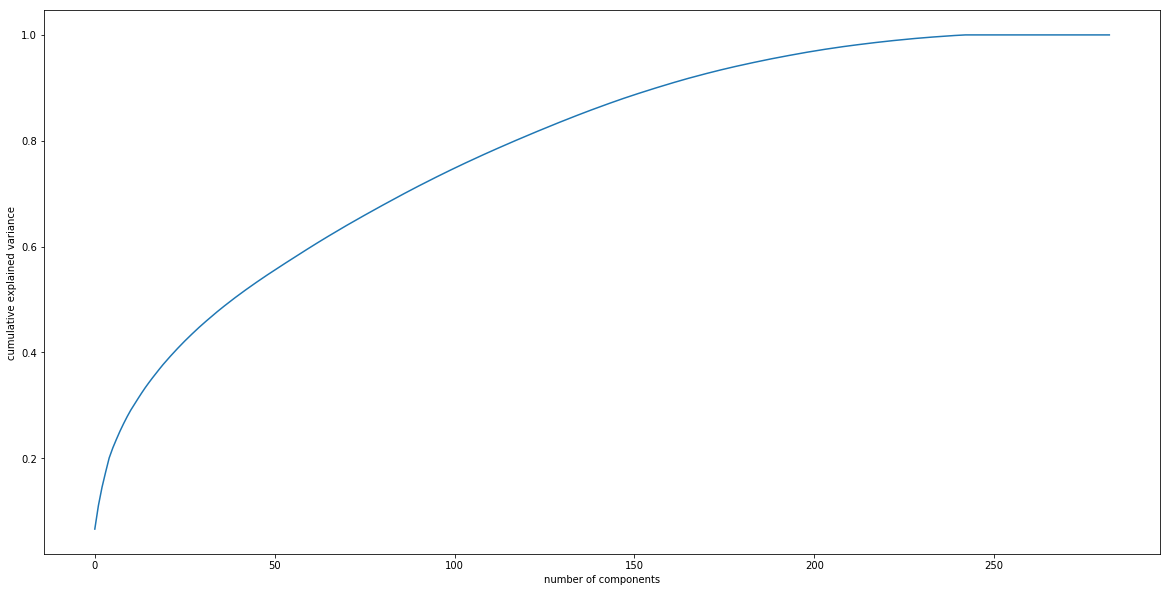

CPU times: user 2min 19s, sys: 7.87 s, total: 2min 27s
Wall time: 3min 38s


In [60]:
%%time
pca = PCA().fit(azdias)
plt.figure(figsize=(20,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [61]:
def print_weights(n):
    '''
    n: number of principal component
    '''
    components = pd.DataFrame(np.round(pca.components_[n - 1: n], 4), columns = azdias.keys())
    components.index = ['Weights']
    components = components.sort_values(by = 'Weights', axis = 1, ascending=False)
    components = components.T
    print(components)
    return components

#### With PCA we want to make our data has high variance. This way we do not lose critical information from dataset while reducing dimensions. Based on above chart we can see that at around 220 components, cumulative variance is still high. Let us reduce our data with 220 components

In [62]:
def reduce_data(df,n=220):
    pca = PCA(n_components=n).fit(df)
    reduced_data = pca.transform(df)
    reduced_data = pd.DataFrame(reduced_data)
    print(pca.explained_variance_ratio_.sum())
    return reduced_data

In [63]:
reduced_azdias = reduce_data(azdias)
reduced_customers = reduce_data(customers)

0.987042529948
0.997359508134


In [64]:
print('number of rows in new dataset: ',reduced_azdias.shape)
print('number of rows in new dataset: ',reduced_customers.shape)

number of rows in new dataset:  (415405, 220)
number of rows in new dataset:  (100341, 220)


### Clustering
**With dimension now reduced, let's do clustering. To decide on number of clusters, we will try using elbow method**

In [65]:
def score(data, k):
    kmeans_k = KMeans(k)
    model_k = kmeans_k.fit(data)
    return abs(model_k.score(data))

In [66]:
centers = np.linspace(1,21,21)
centers

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.])

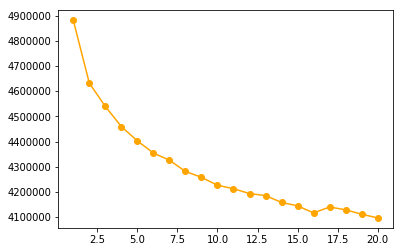

In [67]:
scores = []
for i in range(1, 21):
    scores.append(score(reduced_azdias.sample(20000), i))
centers = np.linspace(1,20,20)
plt.plot(centers, scores, linestyle='-', marker='o', color='orange')

Text(0.5,0,'Number of Clusters')

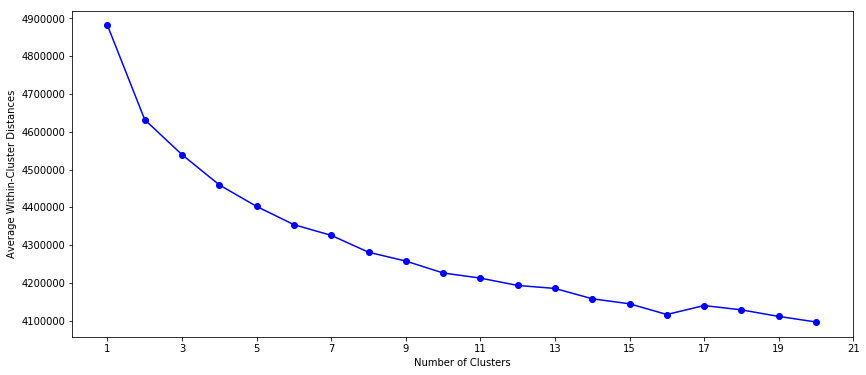

In [68]:
centers = np.linspace(1,20,20)
plt.figure(figsize=(14,6))
plt.plot(centers, scores, linestyle='-', marker='o', color='blue')
plt.xticks(list(range(1,22,2)))
plt.ylabel('Average Within-Cluster Distances')
plt.xlabel('Number of Clusters')

#### From above chart we can see that at around 12 clusters, average distance within cluster almost flattens. We will use 12 as number of clusters

In [69]:
%%time
kmeans_k = KMeans(12)
model_k = kmeans_k.fit(reduced_azdias)
prediction_azdias = model_k.predict(reduced_azdias)

CPU times: user 7min 30s, sys: 14.8 s, total: 7min 45s
Wall time: 8min 18s


In [70]:
azdias_clustered = pd.DataFrame(prediction_azdias, columns = ['Cluster'])

In [71]:
prediction_customers = model_k.predict(reduced_customers)
customers_clustered = pd.DataFrame(prediction_customers, columns = ['Cluster'])

#### Analysis of data in clusters and also comparison between clusters of general population and customer data

In [72]:
# Count number of predictions for each customer segment# Count n 
customer_clusters = pd.Series(prediction_customers)
cc = customer_clusters.value_counts().sort_index()
# Count number in each population segment
population_clusters = pd.Series(prediction_azdias)
pc = population_clusters.value_counts().sort_index()

In [73]:
# Create a dataframe from population and customer segments
df_stat = pd.concat([pc, cc], axis=1).reset_index()
df_stat.columns = ['cluster','population','customer']

df_stat['difference'] = (df_stat['customer']/df_stat['customer'].sum()*100) - (df_stat['population']/df_stat['population'].sum()*100)
df_stat

,cluster,population,customer,difference
0,0,33791,13001,4.822346
1,1,36201,2538,-6.185253
2,2,25856,57,-6.167481
3,3,43770,2995,-7.551883
4,4,42364,14451,4.203649
5,5,26471,1017,-5.358792
6,6,33796,624,-7.513795
7,7,34489,18504,10.138616
8,8,30298,46597,39.145039
9,9,43241,505,-9.906076


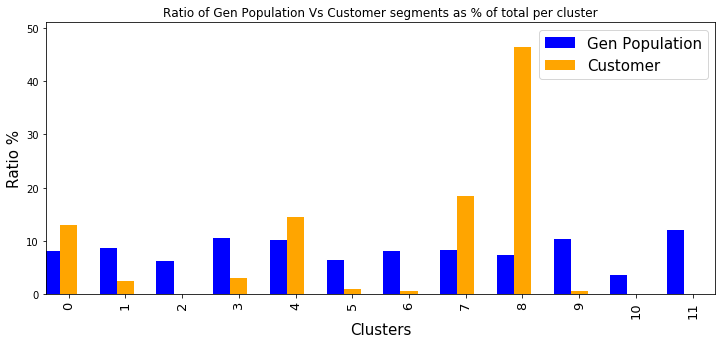

In [74]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
# Add ratio and ratio difference for each cluster to the dataframe
df_stat['pop_percent'] = (df_stat['population']/df_stat['population'].sum()*100).round(2)
df_stat['cust_percent'] = (df_stat['customer']/df_stat['customer'].sum()*100).round(2)


fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(111)
ax = df_stat['pop_percent'].plot(x=df_stat['cluster'],width=-0.3,align='edge',color='blue',kind='bar',position=0)
ax = df_stat['cust_percent'].plot(kind='bar',color='orange',width = 0.3, align='edge',position=1)
ax.set_xlabel('Clusters', fontsize=15) 
ax.set_ylabel('Ratio %', fontsize=15)
ax.xaxis.set(ticklabels=range(20))
ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
ax.margins(x=0.5,y=0.1)

plt.legend(('Gen Population', 'Customer'),fontsize=15)
plt.title(('Ratio of Gen Population Vs Customer segments as % of total per cluster'))
plt.show()

In [75]:
# Show Highest Positive and Negative weights when a PComponent and Weight is passed
def pca_weights(pc,weight_num):
    
    ratio = pd.DataFrame(pca.explained_variance_ratio_,columns = ['EXPLAINED_VARIANCE'])
    ratio = ratio.round(3)
    weights = pd.DataFrame(pca.components_, columns = azdias.columns.values)
    weights = weights.round(3)    
    
    result = pd.concat([ratio, weights], axis = 1,  join_axes=[ratio.index])
    result[:5]
    print("Principal Component: ", (pc))    
    print('\n')
    print("Highest Positive weights:")
    print(result.iloc[(pc)-1].sort_values(ascending=False)[:weight_num])
    print('\n')
    print("Negative weights:")
    print(result.iloc[(pc)-1].sort_values()[:weight_num])

In [76]:
# Show Highest Positive and Negative weights when a PComponent and Weight is passed
def pca_weights(pc,weight_num):
    
    ratio = pd.DataFrame(pca.explained_variance_ratio_,columns = ['EXPLAINED_VARIANCE'])
    ratio = ratio.round(3)
    weights = pd.DataFrame(pca.components_, columns = azdias.columns.values)
    weights = weights.round(3)    
    
    result = pd.concat([ratio, weights], axis = 1,  join_axes=[ratio.index])
    result[:5]
    print("Principal Component: ", (pc))    
    print('\n')
    print("Highest Positive weights:")
    print(result.iloc[(pc)-1].sort_values(ascending=False)[:weight_num])
    print('\n')
    print("Negative weights:")
    print(result.iloc[(pc)-1].sort_values()[:weight_num])

In [77]:
# Show highest positive and negative weights for 10 cluster (over representation of Customer)
pca_weights(10,10)

Principal Component:  10


Highest Positive weights:
KBA05_MAXSEG     0.272
KBA05_KRSOBER    0.208
KBA05_CCM3       0.186
KBA05_HERST1     0.165
KBA05_KW2        0.163
OST_WEST_KZ_O    0.148
KBA05_CCM4       0.139
KBA05_MOD2       0.137
KBA05_DIESEL     0.128
KBA05_GBZ        0.124
Name: 9, dtype: float64


Negative weights:
KBA05_CCM1                -0.235
KBA05_MODTEMP             -0.210
KBA05_HERST3              -0.162
OST_WEST_KZ_W             -0.148
KBA05_HERSTTEMP           -0.137
KBA05_MAXHERST            -0.131
KBA13_CCM_1401_2500       -0.130
KBA13_SEG_GROSSRAUMVANS   -0.127
HH_EINKOMMEN_SCORE        -0.121
KBA05_FRAU                -0.113
Name: 9, dtype: float64


In [78]:
# Show lowest positive and negative weights for 3 cluster (under representation of Customer)
pca_weights(3,10)

Principal Component:  3


Highest Positive weights:
CJT_TYP_1               0.252
ALTERSKATEGORIE_FEIN    0.216
SEMIO_PFLICHT           0.216
FINANZ_ANLEGER          0.215
SEMIO_TRADV             0.212
SEMIO_RAT               0.207
RT_UEBERGROESSE         0.171
RT_KEIN_ANREIZ          0.164
ALTER_HH                0.149
CJT_GESAMTTYP           0.137
Name: 2, dtype: float64


Negative weights:
CJT_TYP_6           -0.232
CJT_KATALOGNUTZER   -0.217
RETOURTYP_BK_S      -0.180
SEMIO_LUST          -0.166
AGER_TYP            -0.148
W_KEIT_KIND_HH      -0.147
FINANZ_MINIMALIST   -0.144
SEMIO_ERL           -0.128
FINANZTYP           -0.112
RT_SCHNAEPPCHEN     -0.078
Name: 2, dtype: float64


In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Analysis of principal components of cluster 2 with over-representation in customer segment.
CC = model_k.cluster_centers_[2]
CC = pd.Series(CC)
CC.index = CC.index +1
print(CC.sort_values(ascending=False).head(5))

# Transform cluster 2 to original feature values.
CC_inv = scale.inverse_transform(pca.inverse_transform(CC))
CC_inv = pd.Series(CC_inv).round(2)
CC_inv.index = azdias_subset_columns
CC_inv

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [80]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [81]:
X = mailout_train.drop('RESPONSE',axis=1)
y = mailout_train['RESPONSE']

In [82]:
# preprocess data
df_mailout_train  = data_preprocess_2(X, False)

shape after corr (42962, 253)
shape after one-hot (42962, 300)
shape after impute (42962, 300)
shape after scaling (42962, 300)


In [83]:
df_mailout_train.shape

(42962, 299)

In [84]:
y.shape

(42962,)

In [85]:
df_mailout_train.head(5)

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_3,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_OFFLINE_DATUM,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,...,KBA13_SEG_KLEINST,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1_2,KBA13_VORB_3,KKK,KONSUMNAEHE,MIN_GEBAEUDEJAHR,MOBI_RASTER,ONLINE_AFFINITAET,PRAEGENDE_JUGENDJAHRE,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_SOZ,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VHA,VHN,VK_DHT4A,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,CAMEO_DEU_2015_-1,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,OST_WEST_KZ_-1,OST_WEST_KZ_O,OST_WEST_KZ_W
LNR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-1.656309,1.031262,-0.545883,-0.371726,-0.428455,0.573402,-0.499090,-0.204857,-0.752038,-0.083831,-0.459891,0.203551,0.355905,0.400669,-0.732206,0.756779,-0.396140,0.563449,0.580973,-0.224018,-0.386557,-0.311376,-0.131465,0.180465,-0.265409,-0.420594,-0.628321,-0.455670,-0.339433,-0.890460,-0.195661,-0.384801,-0.296902,-0.357622,-0.277236,-0.670418,0.332665,-0.614365,-0.656230,-0.499065,-0.506860,1.607224,-0.370249,-0.732580,-0.328887,-0.441823,-0.705592,-0.578366,-0.352762,-1.250845,-0.260739,-0.816325,-0.196130,-0.421768,0.246638,0.084154,-0.030245,-0.351388,-0.216292,-0.399678,-0.267718,0.159771,0.060848,2.183981,1.09062,-0.396608,0.495253,1.059610,0.454064,1.385118,-0.681520,1.036622,-1.638766,0.317880,-1.207588,0.481833,-0.

In [86]:
# Split the dataset into Train/Validation/Test
X_train, X_val, y_train, y_val = train_test_split(df_mailout_train, y, stratify=y, test_size=0.2, random_state=42)

In [87]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train,y_train)

[12:48:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1588600955503/work/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=10, n_jobs=0, num_parallel_tree=1,
       objective='reg:linear', random_state=0, reg_alpha=10, reg_lambda=1,
       scale_pos_weight=1, subsample=1, tree_method=None,
       validate_parameters=False, verbosity=None)

In [88]:
preds = xg_reg.predict(X_val)
preds

array([ 0.18259421,  0.18259421,  0.18259421, ...,  0.18259421,
        0.18259421,  0.18259421], dtype=float32)

In [89]:
print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val, preds)))

ROC score on validation data: 0.5000


#### Model Evaluation and Validation
In terms of evaluation metric to use, I have tried accuracy, precision, recall and fscore but due to very high imbalance (i.e. In MAILOUT_TRAIN dataset, we can find among 43000 individuals, only 532 people response to the mail-out campaign which means the training data is highly imbalanced.), none of these were a good way to measure and then finalised on AUC and ROC as the evaluation metric to proceed.

In [90]:
def train_predict(learner, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train, y_train)
    end = time() # Get end time
    
    # TODO: Calculate the training time
    #results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time
    
    # print('unique predictions_train: ', set(predictions_train))
    
    # TODO: Calculate the total prediction time
    #results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    #results['acc_train'] = accuracy_score(y_train, predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    #results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    #results['prec_train'] = precision_score(y_train, predictions_train)
    #results['recall_train'] = recall_score(y_train, predictions_train)
    
    #results['prec_test'] = precision_score(y_test, predictions_test)
    #results['recall_test'] = recall_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    #results['f_train'] = fbeta_score(y_train, predictions_train, beta=1)
        
    # TODO: Compute F-score on the test set which is y_test
    #results['f_test'] = fbeta_score(y_test, predictions_test, beta=1)
       
    # Success
    #print("{} trained on samples.".format(learner.__class__.__name__))
    
    #results['roc'] = roc_auc_score(y_test, predictions_test)
    
    roc = roc_auc_score(y_test, predictions_test)
        
    # Return the results
    return roc


In [91]:
# Initialize 5 stratified folds
skf = StratifiedKFold(n_splits=5, random_state=42)
skf.get_n_splits(X, y)

5

#### In this project we try 3 algorithms and use evaluation metrics to finalise on the best algorithm to use

In [92]:
alg_abr = AdaBoostRegressor(random_state=42)
alg_gbr = GradientBoostingRegressor(random_state=42)
alg_xgb = XGBRegressor(random_state=42)

In [93]:
result_list = []
for alg in [alg_abr, alg_gbr, alg_xgb]:
    alg_name = alg.__class__.__name__
    
    
    
    j=0
    for train_index, val_index in skf.split(df_mailout_train, y):
    
        j+=1
        #print('Fold {}...'.format(j))
        result = {}  
        result['alg_name'] = alg_name
        result['fold']  =  j
        # Split the data into training and test sets
        X_train, X_val = df_mailout_train.iloc[train_index], df_mailout_train.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        
        
        result['roc'] = train_predict(alg, X_train, y_train, X_val, y_val)
        result_list.append(result)
        print (result)
    
#return result_list    

print('result_list: ', result_list)

{'alg_name': 'AdaBoostRegressor', 'fold': 1, 'roc': 0.7520605681485284}
{'alg_name': 'AdaBoostRegressor', 'fold': 2, 'roc': 0.76112332351690848}
{'alg_name': 'AdaBoostRegressor', 'fold': 3, 'roc': 0.78820888122056743}
{'alg_name': 'AdaBoostRegressor', 'fold': 4, 'roc': 0.72870910578577819}
{'alg_name': 'AdaBoostRegressor', 'fold': 5, 'roc': 0.73072796926347061}
{'alg_name': 'GradientBoostingRegressor', 'fold': 1, 'roc': 0.73311512529708089}
{'alg_name': 'GradientBoostingRegressor', 'fold': 2, 'roc': 0.75193446710469802}
{'alg_name': 'GradientBoostingRegressor', 'fold': 3, 'roc': 0.80506516837943964}
{'alg_name': 'GradientBoostingRegressor', 'fold': 4, 'roc': 0.73210648837819448}
{'alg_name': 'GradientBoostingRegressor', 'fold': 5, 'roc': 0.75577588391979689}
{'alg_name': 'XGBRegressor', 'fold': 1, 'roc': 0.5558291721824401}
{'alg_name': 'XGBRegressor', 'fold': 2, 'roc': 0.60636375250274777}
{'alg_name': 'XGBRegressor', 'fold': 3, 'roc': 0.65723789237767871}
{'alg_name': 'XGBRegressor',

In [94]:
df_scores = pd.DataFrame(result_list)
df_scores

,alg_name,fold,roc
0,AdaBoostRegressor,1,0.752061
1,AdaBoostRegressor,2,0.761123
2,AdaBoostRegressor,3,0.788209
3,AdaBoostRegressor,4,0.728709
4,AdaBoostRegressor,5,0.730728
5,GradientBoostingRegressor,1,0.733115
6,GradientBoostingRegressor,2,0.751934
7,GradientBoostingRegressor,3,0.805065
8,GradientBoostingRegressor,4,0.732106
9,GradientBoostingRegressor,5,0.755776


#### Comparing all the scores

In [95]:
df_scores.groupby('alg_name')['roc'].mean()

alg_name
AdaBoostRegressor            0.752166
GradientBoostingRegressor    0.755599
XGBRegressor                 0.605846
Name: roc, dtype: float64

### Tuning
With GradientBoostingRegressor now finalised, now we need to test and finalise the hyperparameters best suited for our project. Using GridSearchCV to finalise on hyper parameters to use.
Parameters to use:
1. Learning rate: In this parameter i have used the default value 0.1 learning rate shrinks the contribution of each tree by learning_rate. There is a trade-off between learning_rate and n_estimators.
2. N Estimators: I have increased the default value to 500, is the number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
3. Subsample: I have increased the default value to 0.6, the fraction of samples to be used for fitting the individual base learners. If smaller than 1.0 this results in Stochastic Gradient Boosting. subsample interacts with the parameter n_estimators. Choosing subsample < 1.0 leads to a reduction of variance and an increase in bias.
4. Max Depth: In this parameter i have used the default value of 3, is maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree. Tune this parameter for best performance; the best value depends on the interaction of the input variables.

In [96]:
parameters = { 'learning_rate' : [0.1],
                'n_estimators' :[500],
                'subsample' : [0.6],
                'max_depth' : [3]
             }

# Perform grid search on the classifier using 'scorer' as the scoring method
cv = GridSearchCV(alg_gbr, parameters, scoring = 'roc_auc', n_jobs= -1)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = cv.fit(X_train, y_train)

cv.grid_scores_, cv.best_params_, cv.best_score_

# Get the estimator and predict
best_clf = grid_fit.best_estimator_
#predictions = (best_clf.fit(X_train, y_train)).predict(X_test)

best_predictions = best_clf.predict(X_val)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [97]:
roc_auc_score(y_val, best_predictions)

0.72376533602515125

#### Why i am using Roc:
In our model we have a lot of values or categories that could affect if a person would be a potential customer or not, having this objective and knowing that we need to know what categories have most probability on affect our prediction, it is better to use AUC which averages over all possible thresholds. However, if the objective of classification just needs to classify between two possible classes and doesn't require how likely each class is predicted by the model, it is more appropriate to rely on F-score using a particular threshold. So the best way here is use Roc.

### Some more testing to find best hyper parameters

In [98]:
alg_test = GradientBoostingRegressor(learning_rate = 0.1,
                     n_estimators = 500,
                     subsample = 0.6,
                     max_depth = 3)

In [99]:
#from sklearn.cross_validation import KFold, StratifiedKFold

cv = StratifiedKFold(n_splits=2,shuffle=True, random_state=42)

roc_score = []
for train,test in cv.split(X_train,y_train):
    preds = alg_test.fit(X_train,y_train)
    predictions_test = preds.predict(X_val)
    roc_score.append(roc_auc_score(y_val, predictions_test))
    
print(roc_score)

[0.71503341797144238, 0.69778302998501418]


### Final model for scoring and kaggle submission

In [100]:
clf_final = GradientBoostingRegressor(learning_rate = 0.1,
                                         n_estimators = 500,
                                         subsample = 0.6,
                                         max_depth = 3)

preds = clf_final.fit(X_train,y_train)
predictions_test = preds.predict(X_val)
print(roc_auc_score(y_val, predictions_test))

0.698908079456


### We have the best results using GradientBoostingRegressor with GridSearchCV

In [101]:
parameters = { 'learning_rate' : [0.1],
                'n_estimators' :[500],
                'subsample' : [0.6],
                'max_depth' : [3]
             }

# Perform grid search on the classifier using 'scorer' as the scoring method
cv = GridSearchCV(alg_gbr, parameters, scoring = 'roc_auc', n_jobs= -1)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = cv.fit(X_train, y_train)

cv.grid_scores_, cv.best_params_, cv.best_score_

# Get the estimator and predict
best_clf = grid_fit.best_estimator_
#predictions = (best_clf.fit(X_train, y_train)).predict(X_test)

best_predictions = best_clf.predict(X_val)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [102]:
print(roc_auc_score(y_val, best_predictions))

0.723765336025


### Identify and understand important features from supervised learning

In [103]:
feat_importance = clf_final.feature_importances_
feat_importance

array([ 0.00626769,  0.0016451 ,  0.00535931,  0.00827134,  0.01610547,
        0.00481472,  0.01254431,  0.00580746,  0.00486593,  0.0021905 ,
        0.00341375,  0.00415607,  0.00490354,  0.00432158,  0.0025921 ,
        0.00208382,  0.00352233,  0.00348173,  0.01511555,  0.00216715,
        0.00140919,  0.        ,  0.00061356,  0.00140252,  0.00385868,
        0.00135066,  0.00133352,  0.00065865,  0.00238211,  0.00556038,
        0.00200686,  0.00551251,  0.00018805,  0.00076876,  0.00411863,
        0.00588333,  0.00287124,  0.00306043,  0.00205565,  0.00463637,
        0.00132447,  0.00256591,  0.00158526,  0.00513121,  0.0014975 ,
        0.00338749,  0.00197888,  0.00126801,  0.00367674,  0.03001414,
        0.00054397,  0.00105124,  0.00098327,  0.00278716,  0.00285333,
        0.        ,  0.0015586 ,  0.00010893,  0.00013302,  0.00123419,
        0.00436742,  0.00768791,  0.00335434,  0.00254832,  0.00153692,
        0.        ,  0.00595408,  0.00255199,  0.00211313,  0.00

['KBA13_ANZAHL_PKW' 'D19_SOZIALES' 'VERDICHTUNGSRAUM' 'MIN_GEBAEUDEJAHR'
 'ANZ_HAUSHALTE_AKTIV']
[ 0.03909926  0.03001414  0.02451278  0.02027105  0.01610547]


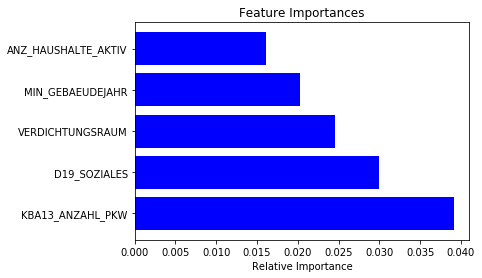

In [104]:
num_feat = 5

indices = np.argsort(feat_importance)[::-1]
columns = X_train.columns.values[indices[:num_feat]]
values = feat_importance[indices][:num_feat]

#print((indices))
print(columns)
print(values)

plt.title('Feature Importances')
plt.barh(np.arange(num_feat), values, color='b', align='center', label = "Feature Weight")
#plt.barh(np.arange(num_feat), np.cumsum(values), color='b', align='center',label = "Cumsum Weight")


plt.yticks(np.arange(num_feat), columns)
plt.xlabel('Relative Importance')
plt.show()

#for name, importance in zip(X_train.column, feat_importance):
#    print(name, "=", importance)

### Analyse this most imp feature from what we learnt earlier in unsupervised learning

In [105]:
# earlier fit of data was done within method so it could not be used now for inverse_transform.
# as we have actual cleaned customer data, lets quickly do pca.

customers_pca = PCA(n_components=220).fit(customers)
customers_pca_data = customers_pca.transform(customers)

Idea is to do comparison between what we identified in supervised learning with what we earlier identified in unsupervised learning

In unsupervised learning we identified various clusters in which some clusters are over represented and some under represented Check how important feature that we identified in GBRegressor is placed in over represented and under represented cluster

**Steps:**
1. Find items in required cluster 
2. Final actual data (reduced) for those items 
3. Do inverse_transform to get full data from reduced data 
4. Find distribution of required column in that dataframe

In [106]:
def get_feat_dist_in_cluster(cluster_number, feature):
    
    # find items in required clustered
    final_items_in_cluster = customers_clustered[customers_clustered['Cluster'] == cluster_number].index
    # get data of items in the identified cluster
    final_reduced_data = reduced_customers.loc[final_items_in_cluster]
    final_data_list = customers_pca.inverse_transform(final_reduced_data)
    final_dataframe = pd.DataFrame(final_data_list, columns=customers.columns.values)
    final_dataframe[feature].hist()

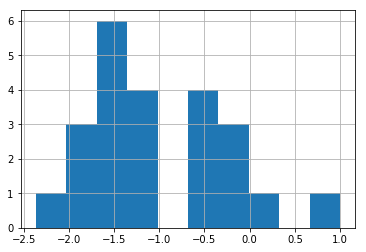

In [107]:
# 10 is the cluster with under representation of customer data in comparison to general population
get_feat_dist_in_cluster(10, 'KBA13_ANZAHL_PKW')

### In Cluster 10 the over represented cluster of customer, there is a single bar

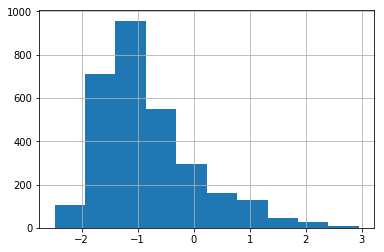

In [108]:
# 3 is the cluster with over representation of customer data in comparison to general population
get_feat_dist_in_cluster(3, 'KBA13_ANZAHL_PKW')

#### In Cluster 3 under represented cluster of customer there is a distribution and not a consolidation in 1 particular value.

# Conclusion: 

### KBA13_ANZAHL_PKW is the numbers of cars in PLZ8 (sub-postcode), so the conclution could be people who has own car or families that shares a car, are most likely to respond to the market campaign and become customer of the mail-order company, maybe because the want to save in gas or avoid drive.

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [109]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [110]:
# as we want to make prediction using model trained with mailout_train, check/make sure this dataset is not different
missing = list(np.setdiff1d(mailout_train.columns, mailout_test.columns))
missing

['RESPONSE']

In [111]:
print('before preprocessing mailout_test.shape: ', mailout_test.shape)
mailout_test_clean = data_preprocess_2(mailout_test, False)
print('after preprocessing mailout_test_clean.shape: ', mailout_test_clean.shape)

before preprocessing mailout_test.shape:  (42833, 366)
shape after corr (42833, 253)
shape after one-hot (42833, 300)
shape after impute (42833, 300)
shape after scaling (42833, 300)
after preprocessing mailout_test_clean.shape:  (42833, 299)


In [112]:
prediction_for_kaggle = clf_final.predict(mailout_test_clean)

In [113]:
df_kaggle = pd.DataFrame(index=mailout_test['LNR'].astype('int32'), data=prediction_for_kaggle)
df_kaggle.rename(columns={0: "RESPONSE"}, inplace=True)

In [114]:
df_kaggle.head(10)

,RESPONSE
LNR,
1754,0.030614
1770,0.021778
1465,0.012279
1470,0.007786
1478,0.102321
1782,-0.009974
1485,-0.001648
1519,0.019296
1835,-0.005497


In [115]:
df_kaggle.to_csv('submission.csv')